In [1]:
import os
import sys
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr


project_dir = "D:/MDSI_project/"
func_dir = "ANSYS_Building_model/PyAPDL_example/FUNC"
doe_dir = "ANSYS_Building_model/PyAPDL_example/DOE_data"
sys.path.append(os.path.join(project_dir, func_dir))
sys.path.append(os.path.join(project_dir, doe_dir))

func_dir_ = os.path.join(project_dir, func_dir)
doe_dir_ = os.path.join(project_dir, doe_dir)

from Simulation_PyAPDL import simulation_PyAPDL
import func_FEMU as FEMU

### Building Surrogate model for ex22 case

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf/")
MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex22 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex22[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,18):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = FEMU.split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = FEMU.split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")
print(np.mean(energy_frf_ex22,axis=0))
print(np.std(energy_frf_ex22,axis=0))

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.9830062917349182, NMSE: 0.016993708265081814
gpr_fn2_ex22 performace: R² Score: 0.9868129191068415, NMSE: 0.013187080893158438
[3.41470545e-16 6.53849500e-17 3.58762444e-17 4.49469446e-17
 1.12159786e-15 8.87818106e-16 2.47977813e-15 1.32193124e-14]
[7.07295996e-16 8.40918779e-17 4.96893533e-17 5.82536189e-17
 1.84072440e-15 1.58724482e-15 4.28333040e-15 2.40226063e-14]


### Sensitivity analysis

                ST   ST_conf
t_sl      0.200154  0.013516
t_cor     0.003063  0.000313
t_g       0.001350  0.000143
t_ew      0.050481  0.003192
t_iw      0.009223  0.000741
e_sl      0.144461  0.008889
e_cor     0.001329  0.000142
e_g       0.002094  0.000199
e_ew      0.028862  0.002230
e_iw      0.008896  0.000934
rho_sl    0.490052  0.028685
rho_cor   0.001775  0.000240
rho_g     0.001146  0.000131
rho_ew    0.001821  0.000192
rho_iw    0.001583  0.000184
soil_vs   0.047187  0.004558
soil_rho  0.014245  0.001590
heig      0.037316  0.002880
DampR     0.000973  0.000106
                S1   S1_conf
t_sl      0.173604  0.023438
t_cor     0.000937  0.003574
t_g       0.000932  0.002377
t_ew      0.049645  0.012208
t_iw      0.010668  0.006005
e_sl      0.140474  0.022110
e_cor     0.000401  0.002074
e_g       0.000806  0.003093
e_ew      0.025314  0.009889
e_iw      0.005004  0.005668
rho_sl    0.483987  0.038786
rho_cor  -0.001339  0.002879
rho_g     0.001464  0.002053
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


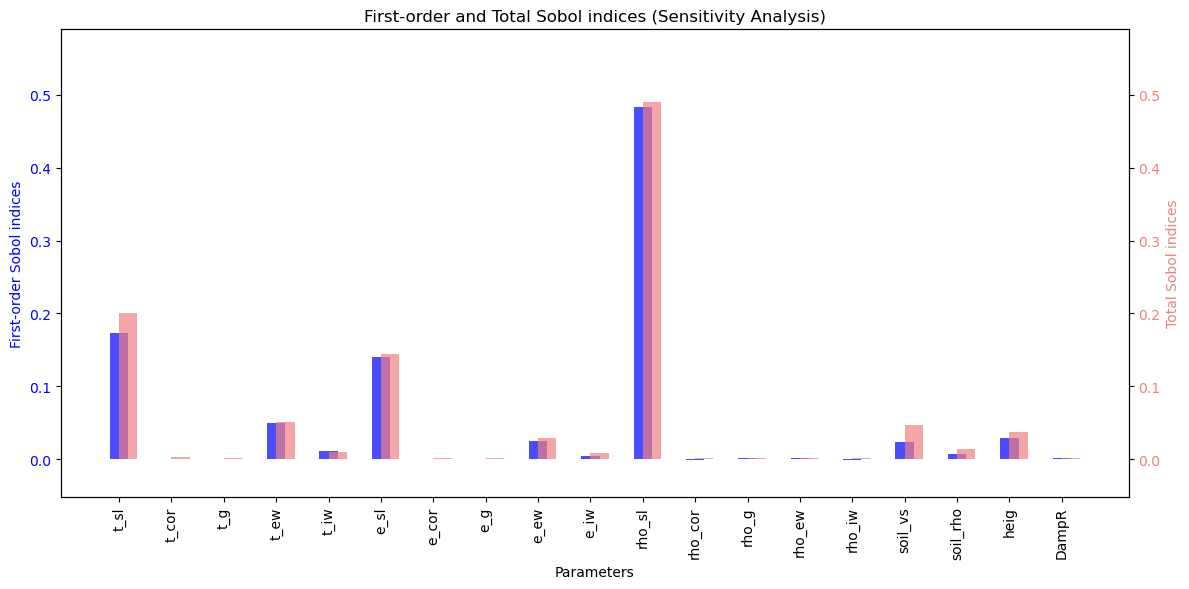

                ST   ST_conf
t_sl      0.522797  0.028468
t_cor     0.006314  0.000574
t_g       0.001110  0.000142
t_ew      0.010973  0.001098
t_iw      0.002872  0.000321
e_sl      0.188877  0.012416
e_cor     0.002185  0.000261
e_g       0.001157  0.000137
e_ew      0.003316  0.000369
e_iw      0.002112  0.000250
rho_sl    0.277352  0.019588
rho_cor   0.001555  0.000200
rho_g     0.001232  0.000146
rho_ew    0.002919  0.000324
rho_iw    0.002468  0.000321
soil_vs   0.001964  0.000230
soil_rho  0.001449  0.000187
heig      0.016220  0.001550
DampR     0.001613  0.000220
                S1   S1_conf
t_sl      0.504174  0.041279
t_cor     0.003623  0.004688
t_g       0.001069  0.002094
t_ew      0.007755  0.006510
t_iw     -0.000709  0.003748
e_sl      0.172795  0.026930
e_cor     0.001958  0.002624
e_g      -0.000610  0.002052
e_ew      0.002169  0.003734
e_iw      0.002784  0.002644
rho_sl    0.261626  0.030769
rho_cor   0.001040  0.002337
rho_g    -0.000421  0.002210
rho_ew   -0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


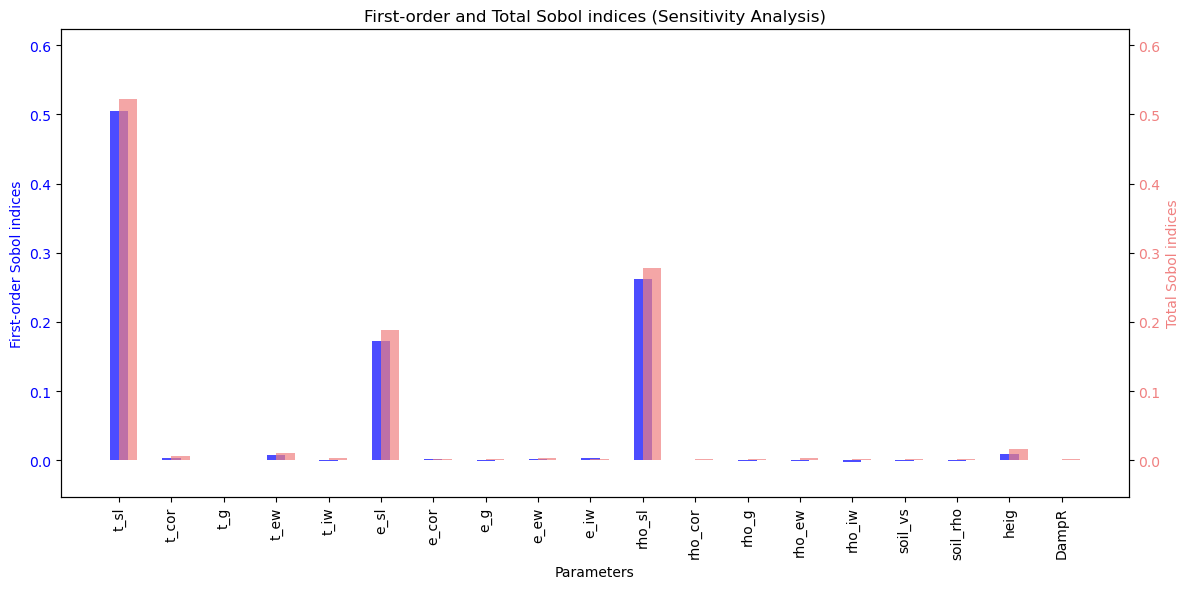

In [3]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
Si_fn1_ex22 =  FEMU.sobol_GSA(gpr_fn1_ex22,19,2048,input_name,True)
Si_fn2_ex22 =  FEMU.sobol_GSA(gpr_fn2_ex22,19,2048,input_name,True)

### GA optimization, checking reproducability

In [6]:
import numpy as np
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
from scipy.stats import qmc

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]


# Objective function: minimize the difference from target
def objective_function(x_):
    #x = np.array(x)
    x = 0.5*np.ones(19)
    x[0] = x_[0]
    x[3] = x_[1]
    x[4] = x_[2]
    x[5] = x_[3]
    x[8] = x_[4]
    x[10] = x_[5]
    x[15] = x_[6]
    x[16] = x_[7]
    x[17] = x_[8]
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2,)
    #return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2,)

bounds = [(0, 1) for _ in range(9)]  # Example bounds
# Height should be in smaller range
# Remaining significant parameter: 0,3,4,5,8,10,15,16,17
# Using correlation: 0,3,5,8,9,10,17,18
bounds[8] = (0.3,0.7)

# Define parameter bounds (example: [(low1, high1), (low2, high2), ...])
#bounds = [(0, 10), (50, 100), (0.1, 1.0)]  # Example bounds for each parameter
num_params = len(bounds)
population_size = 4000  # Define population size



# Generate LHS samples
sampler = qmc.LatinHypercube(d=num_params)  # d = number of parameters
lhs_samples = sampler.random(n=population_size+1)  # Generate population_size samples
scaled_samples = qmc.scale(lhs_samples, [b[0] for b in bounds], [b[1] for b in bounds])  # Scale to bounds

# Custom parameter generator using LHS
lhs_population = scaled_samples.tolist()  # Convert to a list of lists
def generate_individual():
    """Populates from the pre-generated LHS samples."""
    if not lhs_population:
        raise ValueError("LHS population is exhausted! Increase the number of samples.")
    return lhs_population.pop(0)

# Define the fitness function (minimization problem)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Population generator

# Register genetic operators
toolbox.register("evaluate", objective_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Population size and generations
population = toolbox.population(n=population_size)  # Population of 100 individuals

# Run the genetic algorithm
num_generations = 500
result_population, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                                             stats=None, halloffame=None, verbose=True)

# Evaluate all individuals and sort them
evaluated_population = [(ind, objective_function(ind)) for ind in result_population]
sorted_population = sorted(evaluated_population, key=lambda x: x[1])  # Sort by fitness

# Top 10 candidates
top_10_candidates = sorted_population[:30]

# Print the results
for idx, (candidate, score) in enumerate(top_10_candidates):
    print(f"Rank {idx+1}: Parameters = {candidate}, Objective = {score}")



c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	4000  
1  	3041  
2  	3060  
3  	2970  
4  	3093  
5  	3032  
6  	3055  
7  	3024  
8  	3065  
9  	3056  
10 	3044  
11 	3040  
12 	3049  
13 	3078  
14 	3061  
15 	3066  
16 	3076  
17 	3044  
18 	3069  
19 	3080  
20 	3032  
21 	3048  
22 	3021  
23 	3039  
24 	3013  
25 	3109  
26 	3021  
27 	2993  
28 	3086  
29 	3101  
30 	3087  
31 	3009  
32 	3055  
33 	3061  
34 	3020  
35 	3018  
36 	3060  
37 	3044  
38 	3102  
39 	3041  
40 	3008  
41 	3008  
42 	2999  
43 	2993  
44 	3022  
45 	3025  
46 	3071  
47 	3027  
48 	3117  
49 	3028  
50 	3034  
51 	3017  
52 	3050  
53 	3066  
54 	3094  
55 	3045  
56 	3071  
57 	3060  
58 	2995  
59 	3007  
60 	3022  
61 	3072  
62 	3048  
63 	3093  
64 	3040  
65 	2978  
66 	2999  
67 	3005  
68 	3019  
69 	3047  
70 	3059  
71 	3072  
72 	3023  
73 	3047  
74 	3035  
75 	3106  
76 	3084  
77 	3016  
78 	3015  
79 	3139  
80 	3074  
81 	3042  
82 	3119  
83 	3011  
84 	3031  
85 	2975  
86 	3046  
87 	2998  
88 	3121  
89 	3006  

Rank 1: Parameters = [0.8631000352009177, 0.21182435645369813, 0.48720123406416227, 0.7326868956944581, 0.29927954028288556, 0.7194748227624141, 0.37885548367441674, 1.0856286427939963, 0.6004297091599589], Objective = (8.428483474923115e-16,)

### L-BFGS-B optimization

In [5]:
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0.5, 0.5) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[4]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[10] = (0,1)
bounds[15] = (0,1)
bounds[16] = (0,1)
bounds[17] = (0,1)


# Initial guess for the parameters
#x0 = np.random.uniform(0, 1 ,size=19)
id_ = 0
x0 = 0.5*np.ones(19)


x0[0]  = top_10_candidates[id_][0][0]
x0[3]  = top_10_candidates[id_][0][1]
x0[4]  = top_10_candidates[id_][0][2]
x0[5]  = top_10_candidates[id_][0][3]
x0[8]  = top_10_candidates[id_][0][4]
x0[10] = top_10_candidates[id_][0][5]
x0[15] = top_10_candidates[id_][0][6]
x0[16] = top_10_candidates[id_][0][7]
x0[17] = top_10_candidates[id_][0][8]

#x0 = top_10_candidates[5][0]

x_top_10_candidates = np.zeros([10,19])
print(x0)

for i_top in range(1):
    # Perform optimization
    result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

    # Optimized parameters
    if result.success:
        optimized_params = result.x
        print("Optimized Parameters:", optimized_params)
        print("Objective Function Value:", result.fun)
        print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
        print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
        x_top_10_candidates[i_top,:] = result.x
        
    else:
        print("Optimization failed:", result.message)

# Identify rows that are not all zeros
non_zero_rows = ~np.all(x_top_10_candidates == 0, axis=1)
# Remove rows with all zeros
x_top_10_candidates = x_top_10_candidates[non_zero_rows]
x_top_10_candidates = np.unique(x_top_10_candidates, axis=0)
print(x_top_10_candidates)

[0.86310004 0.5        0.5        0.21182436 0.48720123 0.7326869
 0.5        0.5        0.29927954 0.5        0.71947482 0.5
 0.5        0.5        0.5        0.37885548 1.08562864 0.60042971
 0.5       ]
Optimized Parameters: [0.99999981 0.5        0.5        0.60115624 0.27049226 0.81256295
 0.5        0.5        0.53020493 0.5        0.71947482 0.5
 0.5        0.5        0.5        0.37885548 1.         0.60042971
 0.5       ]
Objective Function Value: 1.17141364972981e-10
goal fn_1:12.1344, fn_2:18.8672
fn_1: 13.495021793249492, fn_2: 21.025326755574653
[[0.99999981 0.5        0.5        0.60115624 0.27049226 0.81256295
  0.5        0.5        0.53020493 0.5        0.71947482 0.5
  0.5        0.5        0.5        0.37885548 1.         0.60042971
  0.5       ]]


Optimized Parameters: [0.99999981 0.5        0.5        0.60115624 0.27049226 0.81256295
 0.5        0.5        0.53020493 0.5        0.71947482 0.5
 0.5        0.5        0.5        0.37885548 1.         0.60042971
 0.5       ]